In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [2]:
def read_log_file(run_dir):
    with open(run_dir+"/log.txt","r") as fi:
        line=fi.readline()
        exp_params=json.loads(line)
        line=fi.readline()
        assert(line.startswith("#"))
        df=pd.read_csv(fi)
        df=df[df.epoch!="epoch"]
        df=df.reset_index(drop=True)
        type_dict={'p@1': 'float',
                   'p@3': 'float',
                   'p@5': 'float',
                   'ranking_loss': 'float',
                   'coverage_error': 'float',
                   'avg_prec_score': 'float',
                   'loss': 'float',
                   'epoch': 'float'}
        df=df.astype(type_dict)
        df=df.astype({'epoch': 'int'})
        return exp_params,df

In [3]:
def get_compound_df(run_dirs,param_key,get_run_name):
    all_df=None
    for run_dir in run_dirs:
        ep,df=read_log_file(run_dir)
        df.loc[:,"run"]=get_run_name(ep[param_key])
        if all_df is None:
            all_df=df
        else:
            all_df=all_df.append(df)
    return all_df

In [4]:
def make_plots(all_df,metric_names=["p@1","ranking_loss","coverage_error","avg_prec_score"]):
    num_plots=len(metric_names)+1
    fig,axes=plt.subplots(num_plots,1,squeeze=False,figsize=(8,8*num_plots))
    # plot training loss
    myax=axes[0][0]
    myax.set_title("Training loss")
    filtered=all_df[all_df["trn/val"]=="trn"]
    sb.lineplot(x="epoch",y="loss",hue="run",data=filtered,ax=myax)
    for i,mname in enumerate(metric_names):
        myax=axes[i+1][0]
        myax.set_title(mname)
        sb.lineplot(x="epoch",y=mname,hue="run",style="trn/val",data=all_df,ax=myax)

The following are the plots of few experiments exploring hyperparameters for the **bibtex** dataset.

The default parameter values for the following experiments are as follows
* The network has 1 hidden layer with 1000 units unless mentioned otherwise.
* The margin for the triplet margin loss is chosen as 0.
* The dimension of the embedding space is taken as 30.
* A simple averaging nearest neighbour model with 20 neighbours is used for evaluation.

### Embedding dimension

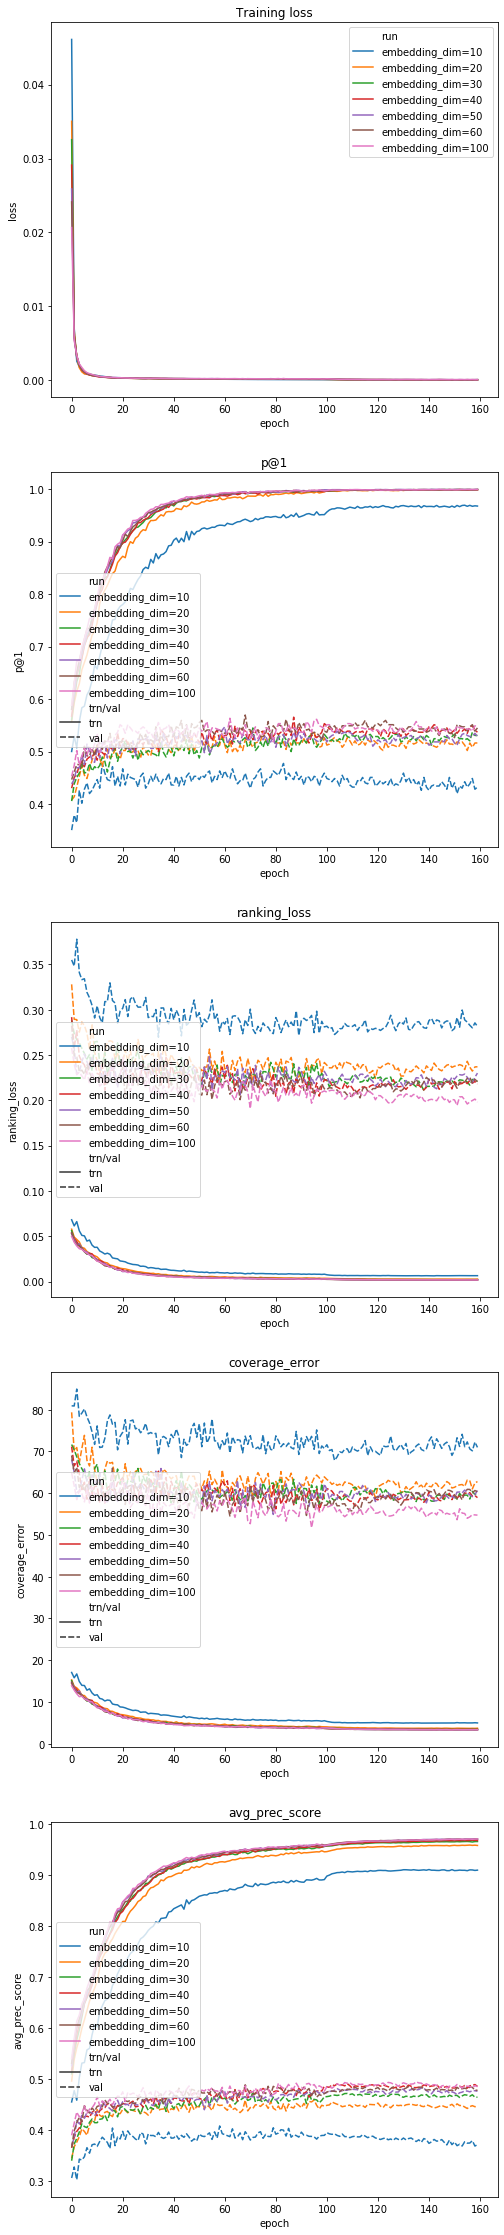

In [5]:
run_dirs=["../runs/bibtex_10","../runs/bibtex_20","../runs/bibtex_30","../runs/bibtex_40",
         "../runs/bibtex_50","../runs/bibtex_60","../runs/bibtex_100"]
param_key="embedding_dim"
all_df=get_compound_df(run_dirs,param_key,lambda x : param_key+"="+str(x))
make_plots(all_df)

* **There seems to be an increase in performance with increase in embedding dimension, gains plateauing at 40.**
* Interestingly coverage_error and ranking_loss which are more sensitive to tail label performance seem to be least for embedding dimension of 100.

### Margin 

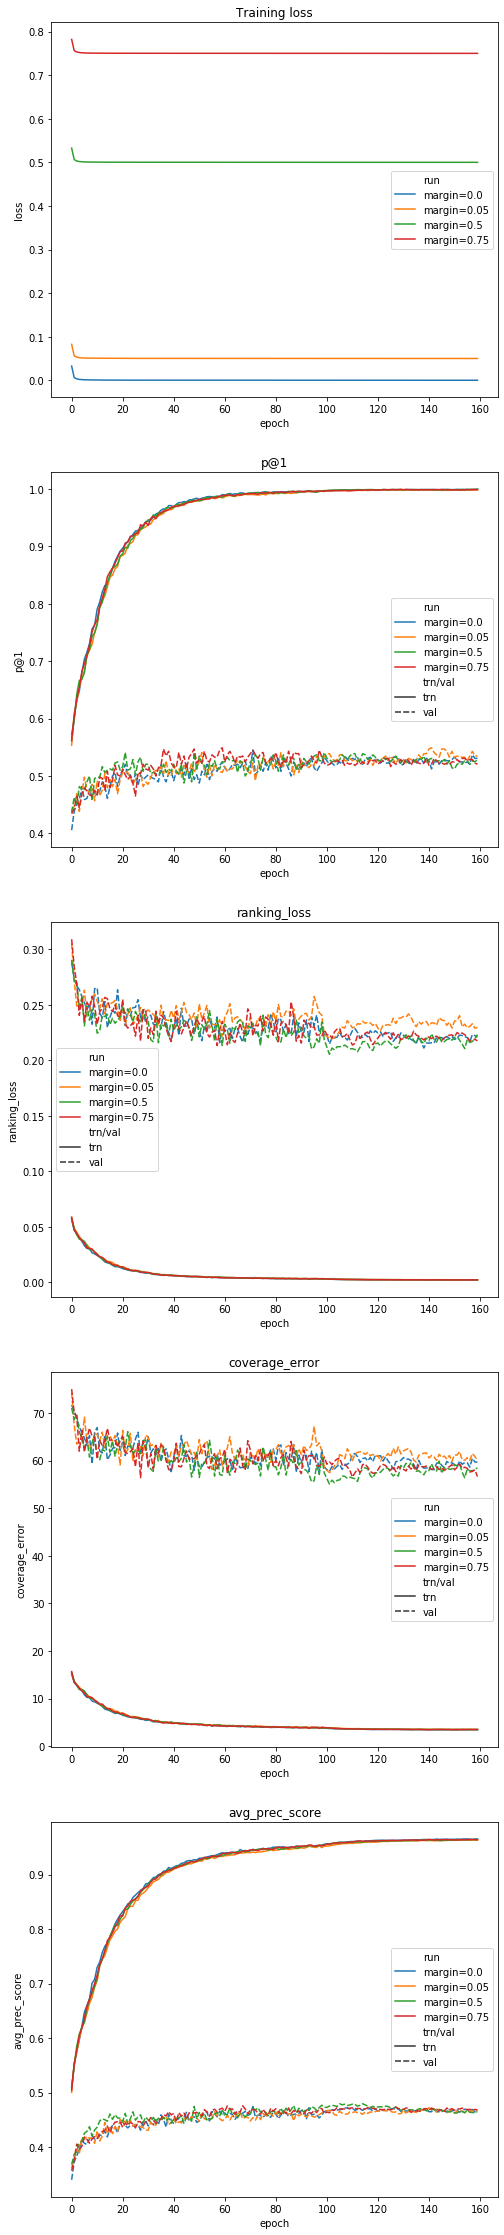

In [6]:
run_dirs=["../runs/bibtex_30","../runs/bibtex_30_marg_0_05","../runs/bibtex_30_marg_0_5","../runs/bibtex_30_marg_0_75"]
param_key="trips_margin"
all_df=get_compound_df(run_dirs,param_key,lambda x : "margin="+str(x[0][1]))
make_plots(all_df)

* There seems to have been a slightly better performance with a large margin=0.5, but the gains on the validation set don't seem to be very significant.
* In the multilabel setting, it is not clear whether we should have a large margin, as there is no positive/negative distinction. **In the future we can experiment with a margin proportional to the similarity difference, instead of a constant margin.**

### Number of Hidden Layers

The size of each hidden layer is taken as 1000.

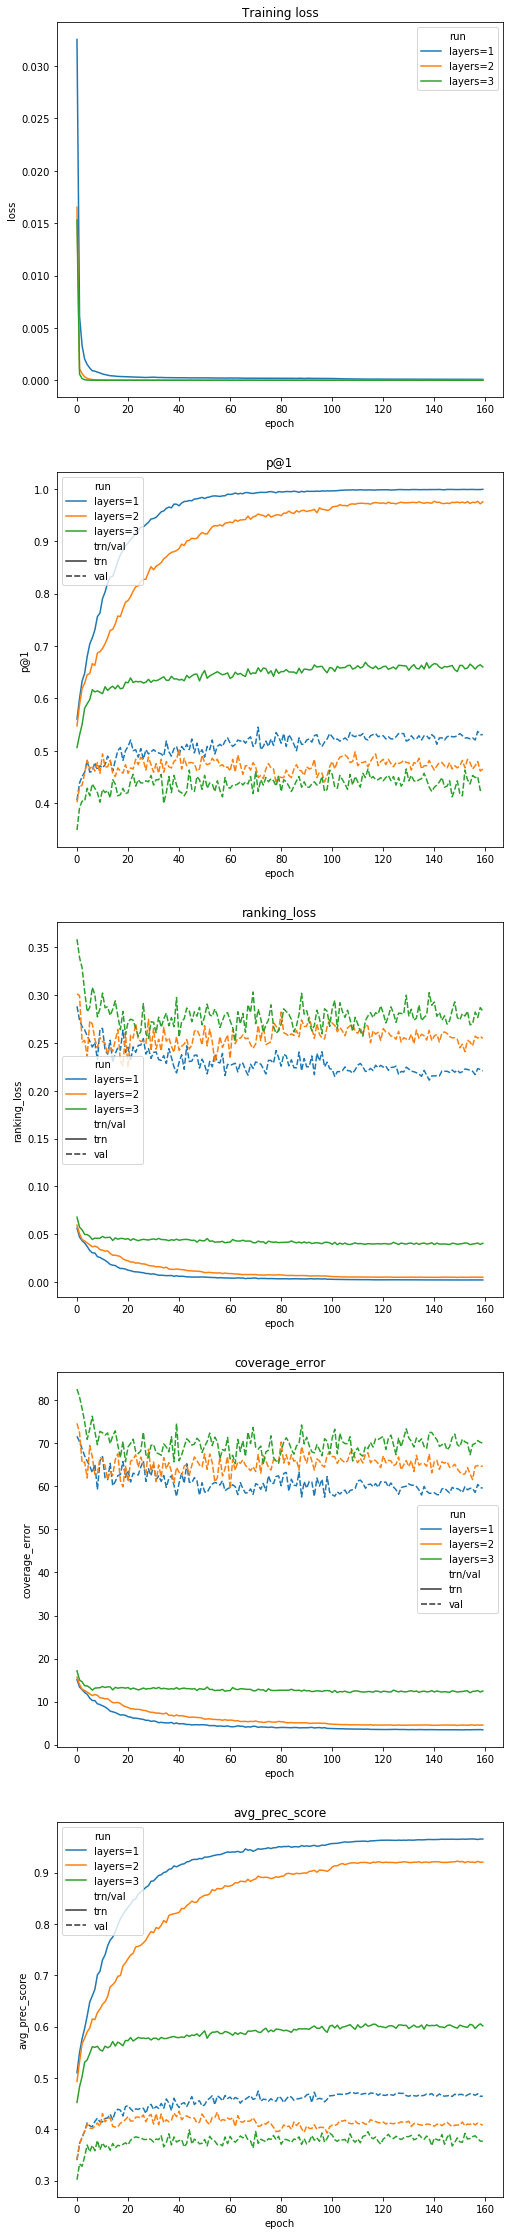

In [7]:
run_dirs=["../runs/bibtex_30","../runs/bibtex_30_h2","../runs/bibtex_30_h3"]
param_key="model_layers"
all_df=get_compound_df(run_dirs,param_key,lambda x:"layers="+str(len(x)-2))
make_plots(all_df)

* **Models with more than a single hidden layer do not perform very well.** This is expected, as it is the same case for a binary cross entropy objective (observed in separate experiments). This is possibly related to the efficacy of linear classifiers for high-dimensional sparse (featured) datasets.

### Hidden units (Single Layer Network)

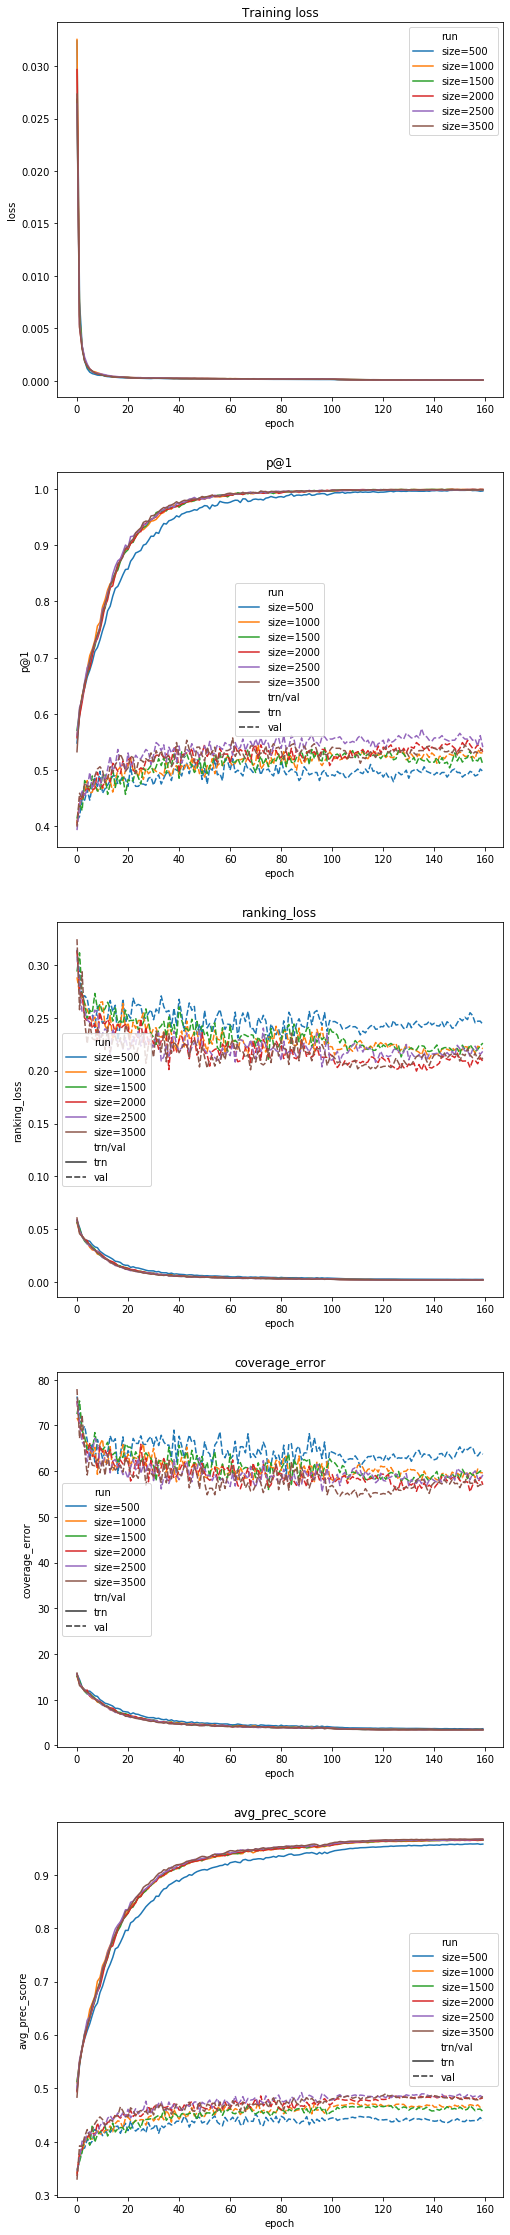

In [8]:
run_dirs=["../runs/bibtex_30_500","../runs/bibtex_30","../runs/bibtex_30_1500",
          "../runs/bibtex_30_2000","../runs/bibtex_30_2500","../runs/bibtex_30_3500"]
param_key="model_layers"
all_df=get_compound_df(run_dirs,param_key,lambda x : "size="+str(x[1]))
make_plots(all_df)

* **Increase in hidden layer size is accompanied with better performance plateauing after about 2000.**

### Discounted Similarities

To tackle label imbalance, one simplistic method is to discount the similarity contributions of a label as a function of its count. The intuition is that a "rare label similarity" between two points is more important than a "common label similarity", and so the sampling procedure will choose the points with a rare label in common as a positive w.r.t. a point with a common label similarity.

1. Method 0 ~ is no such discounting. A common label adds 1 to the similarity score.
2. Method 1 ~ A common label adds 1/log(rank(label)+1) to the similarity score.
3. Method 2 ~ A common label adds 1/log(count(label)+1) to the similarity score.

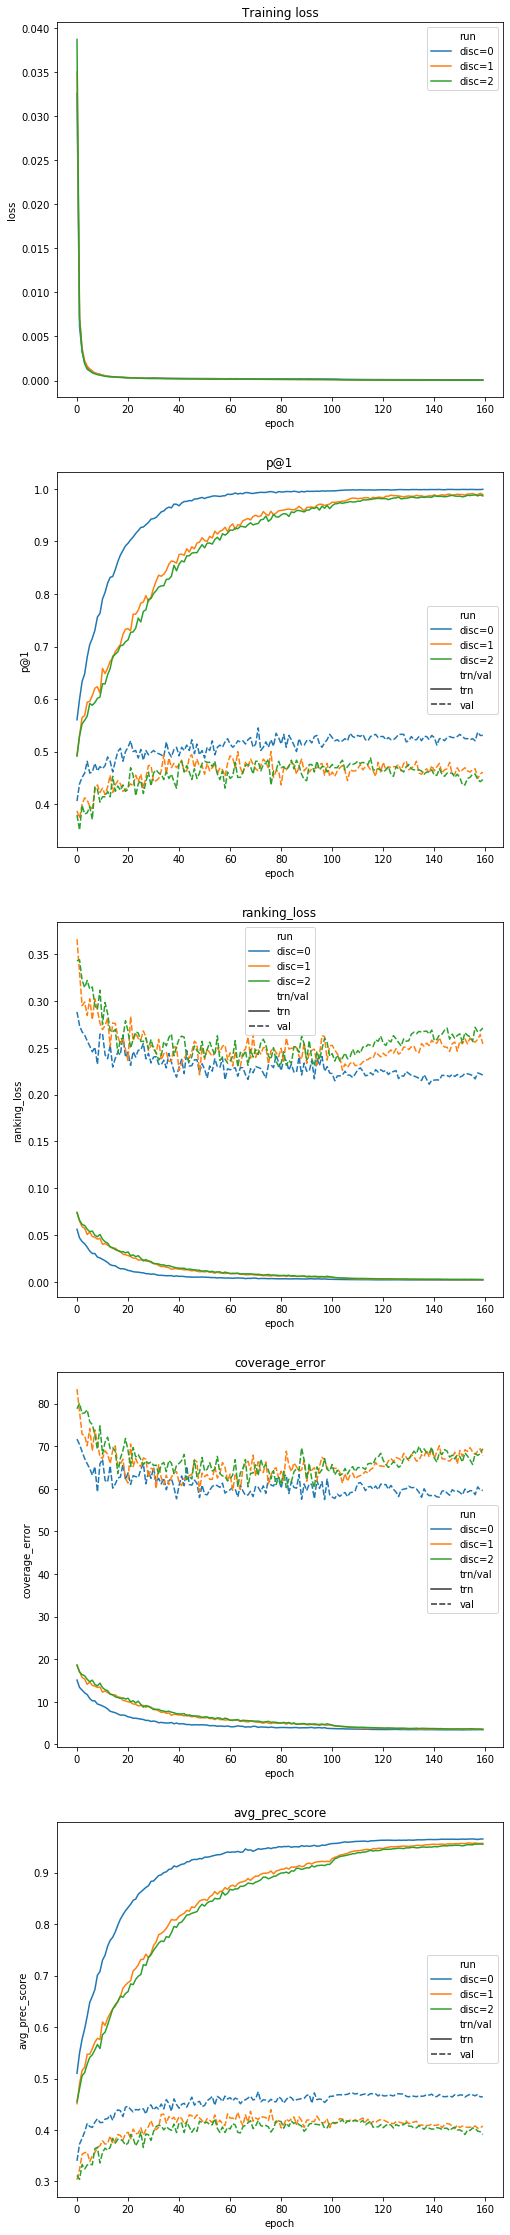

In [9]:
run_dirs=["../runs/bibtex_30","../runs/bibtex_30_disc_1","../runs/bibtex_30_disc_2"]
param_key="disc"
all_df=get_compound_df(run_dirs,param_key,lambda x : "disc="+str(x))
make_plots(all_df)

**Clearly the discounting methods hinder the performance.** 

Currently, we are constructing minibatches randomly. This is of course, unfavourable to rare labels. We can construct minibatches to contain all/minimum points of a single/all rare labels instead. 